Load libraries. In practice, you would rarely work with Jupyter notebooks, but with Python scripts instead. In that case, you would set up environments, in which you install these packages.

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, diff
%matplotlib inline

Let's look at a simple 1-D function and its implementation in Python.

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

We can evaluate this function easily by calling it.

In [3]:
f(3.0)

20.0

We can also plot it easily.

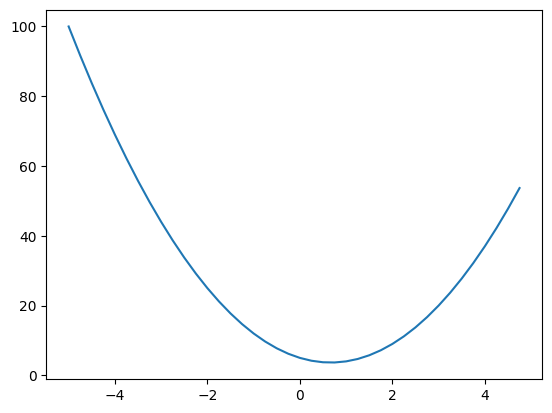

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

However, how do we obtain the derivate of it? We can get the numerical derivate by computing the finite difference quotient for a small h. Please compute it at x=2/3. You should get a value close to 0.
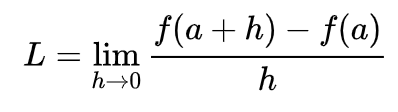

In [5]:
x0 = 2/3
h = 0.00000001
derivative = (f(x0 + h) - f(x0)) / h
derivative

0.0

Not too bad. But, you can already see an error. This is supposed to be zero as the analytical derivate shows:

In [6]:
# Define the symbol
x = symbols('x')

# Define the function
f = 3*x**2 - 4*x + 5

# Compute the derivative
f_derivative = diff(f, x)
print("Derivative: ", f_derivative)


f_derivative_at_x = f_derivative.subs(x, x0)
print("Derivative at x0=2/3: ", f_derivative_at_x.evalf())


Derivative:  6*x - 4
Derivative at x0=2/3:  0


You can image that this numerical error can becomes huge if applied to more complicated functions. Instead, we can compute the solution analytically much more accurately using backpropagation. We want to "track" gradients for arbitrary algebraic operations to backpropagte these to update the weights in our neural network. For that, consider the following chain of operations

In [7]:
# let's get much more complex ;)
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


Again, we could compute the finite difference quotient. Next to the reason mentioned above (accumulating errors), how would we get the individual derivatives of the weights? We could just compute the finite differences for each weight individually as can be seen here. Please compute the derivate of d with respect to b.

In [8]:
# Function definition
def d_function(a, b, c):
    return a * b + c

# Finite difference quotient parameters
h = 0.01  # small step

# Derivatives calculation
# Derivative with respect to a
d_derivative_wrt_a = (d_function(a + h, b, c) - d_function(a, b, c)) / h

# Derivative with respect to b
d_derivative_wrt_b = (d_function(a, b + h, c) - d_function(a, b, c)) / h

# Derivative with respect to c
d_derivative_wrt_c = (d_function(a, b, c + h) - d_function(a, b, c)) / h

# Print the results
print(f"Derivative of d with respect to a: {d_derivative_wrt_a}")
print(f"Derivative of d with respect to b: {d_derivative_wrt_b}")
print(f"Derivative of d with respect to c: {d_derivative_wrt_c}")

Derivative of d with respect to a: -2.999999999999936
Derivative of d with respect to b: 1.9999999999999574
Derivative of d with respect to c: 0.9999999999999787


This would require us to do three forward passes (# of parametrers many) of the network. It would not be trivial to modify the finite difference quotients to make them work with fewer forward passes.

Instead, we will look at a simple framework that can comnpute all the partial derivates using only a single forward and backward pass analytically (so without any numerical errors coming from approximations (except for the floating point approximations naturally ;) ))

In [9]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"


a = Value(2.0); a.label='a'
b = Value(-3.0); b.label='b'
c = Value(10.0); c.label='c'
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
print(d)

Value(data=4.0, grad=0)


Please familiarize yourself with this class. Essentially, a Value instance can be seen as a weight in a neural network. Instead of just being a number though, it holds information about its gradient, too. There are a bunch of helper functions for visualizations and some essential methods for doing computing the gradient.

Please add the activation function tanh.

We may visualize this graph by having the following visualization functions.

In [10]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


Drawing works as follows:

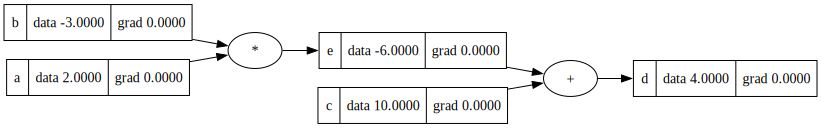

In [11]:
draw_dot(d)

So far, no gradient has been computed. As they are initialized with zero, the weights don't change when we try to update the weights.

In [12]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad

e = a * b
d = e + c

print(d.data)


4.0


Using the "Value" instances, we can do the same finite differences derivate as before. E.g. here the derivate of d with respect to b. Compare that to the analytical derivate of b. Does it coincide?

In [13]:
h = 0.001

a = Value(2.0); a.label='a'
b = Value(-3.0); b.label='b'
c = Value(10.0); c.label='c'
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
d1 = d.data

a = Value(2.0); a.label='a'
b = Value(-3.0); b.label='b'
b.data += h
c = Value(10.0); c.label='c'
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
d2 = d.data

print((d2 - d1)/h)



1.9999999999997797


Let's do it via backpropagation. This is as simple as calling the backward method on the output node (d in this case).

In [14]:
a = Value(2.0); a.label='a'
b = Value(-3.0); b.label='b'
c = Value(10.0); c.label='c'
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'

d.backward()
print("gradient of d with respect to b: ", b.grad)

gradient of d with respect to b:  2.0


We got the same result (just more accurate) as in the finite difference approach 🥳

Because you came so far, you don't have to do part (c) of the assignment sheet. It's already included 🎂

Let's do backpropagation now with a simple "MLP" network defined as follows.

In [15]:
# inputs x1,x2
x1 = Value(2.0); x1.label='x1'
x2 = Value(1.0); x2.label='x2'
# weights w1,w2
w1 = Value(-3.0); w1.label='w1'
w2 = Value(1.0); w2.label='w2'
# bias of the neuron
b = Value(6.8813735870195432); b.label='b'
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.relu(); o.label = 'o'

This looks as follows.

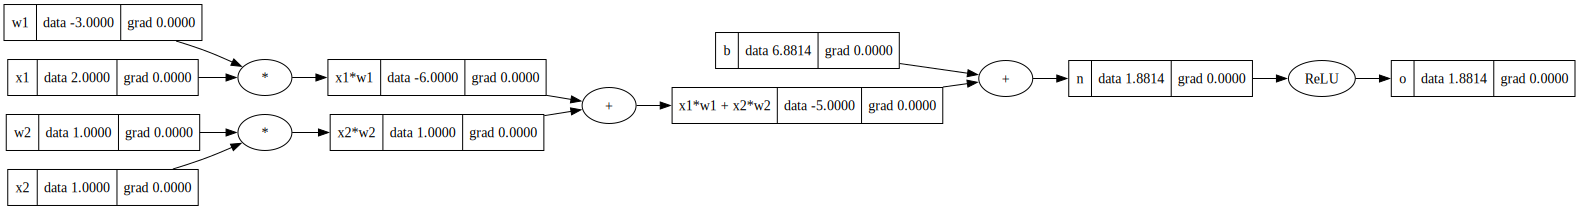

In [16]:
draw_dot(o)

Computing the gradients via backpropagation again.

In [17]:
o.backward()

We can see all the gradients, e.g. with respect to b and w1.

In [18]:
print("gradient wrt to b: ", b.grad)
print("gradient wrt to w1: ", w1.grad)

gradient wrt to b:  1
gradient wrt to w1:  2.0


What happens when we call .backward()?

To understand that, let first look at the order of nodes that have been visited. This is also included in the Value class.

In [19]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543, grad=1),
 Value(data=1.0, grad=1.0),
 Value(data=1.0, grad=1.0),
 Value(data=1.0, grad=1),
 Value(data=2.0, grad=-3.0),
 Value(data=-3.0, grad=2.0),
 Value(data=-6.0, grad=1),
 Value(data=-5.0, grad=1),
 Value(data=1.8813735870195432, grad=1),
 Value(data=1.8813735870195432, grad=1)]

We can see that the output node is last in that list.

Let's recall the network structure:

In [20]:
# inputs x1,x2
x1 = Value(2.0); x1.label='x1'
x2 = Value(1.0); x2.label='x2'
# weights w1,w2
w1 = Value(-3.0); w1.label='w1'
w2 = Value(1.0); w2.label='w2'
# bias of the neuron
b = Value(6.8813735870195432); b.label='b'
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.relu(); o.label = 'o'

Now, calling .backward() on the final node does do the following:

First, we set the last gradient as 1.

In [21]:
o.grad = 1.0

Then, we call the _backward function on all the nodes individually in reversed order.

In [22]:
o._backward()

In [23]:
n._backward()

In [24]:
b._backward()

In [25]:
x1w1x2w2._backward()

In [26]:
x2w2._backward()
x1w1._backward()

This leads to the same gradient as before. E.g. for w1 (compare to above).

In [27]:
w1.grad

2.0

With such an easy framework, can also do "more complicated" networks with cross connections, e.g.:

output is  Value(data=-6.0, grad=0)
derivate with respect to a:  -3.0


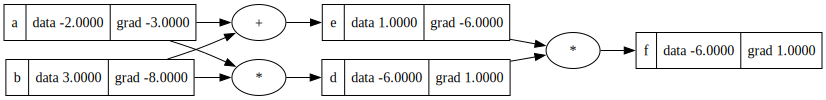

In [28]:
a = Value(-2.0);  a.label='a'
b = Value(3.0) ;  b.label='b'
d = a * b      ;  d.label = 'd'
e = a + b      ;  e.label = 'e'
f = d * e      ;  f.label = 'f'
print("output is ", f)
f.backward()

print("derivate with respect to a: ", a.grad)

draw_dot(f)

Note that here we computed the gradient with respect to the input nodes a and b. This is perfectly fine and is done in some applications.

Just as a teaser: Later, we will use PyTorch instead of our simple example framework. In PyTorch, the same network would be formulated as follows.

In [29]:
import torch

In [30]:
a = torch.Tensor([-2.0]).double()                ; a.requires_grad = True
b = torch.Tensor([3.0]).double()                 ; b.requires_grad = True
o = a * b * (a + b)

print(o.data.item())
o.backward()

print('---')
print('derivate with respect to a', a.grad.item())


-6.0
---
derivate with respect to a -3.0




---



With the atomic building block of a "Value" instance, we can define neurons, layers, and a fully fletched MLP. For that, see the following classes:

In [31]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

You almost made it. Just some explanations:

*   The Module class is just for setting the gradient to zero (which we will do after each gradient descent step) and to collect the parameters of the network (which we might need, e.g. to compute the size of our network).
*   The Neuron class consists of weights, biases, and an activation function.
*   The Layer class now combines the Neurons into layers.
*   The MLP class is the final abstraction, building an MLP out of the layers.

As a gift, you also get part (d) for free 🚀

With these modules/classes, we can define our first neural network.

In [32]:
# initialize a model
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


Let's load the moon/spiral dataset:

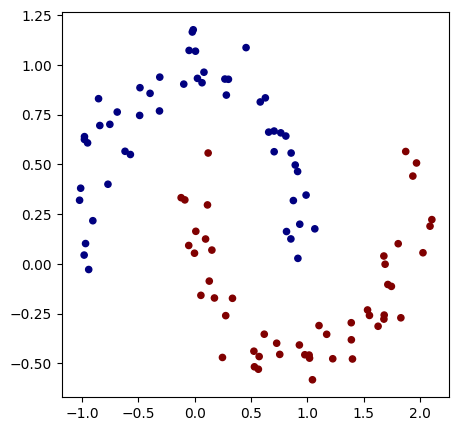

In [33]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

We may define our loss function:

In [34]:
# loss function
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.6061369446523899, grad=0) 0.5


And finally define the optimization loop.

In [35]:
# optimization
for k in range(100):

    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 1.6061369446523899, accuracy 50.0%
step 1 loss 0.694003584108366, accuracy 83.0%
step 2 loss 0.9163563208344688, accuracy 79.0%
step 3 loss 0.3183470863297861, accuracy 86.0%
step 4 loss 0.30576441686731787, accuracy 86.0%
step 5 loss 0.2945300971083333, accuracy 87.0%
step 6 loss 0.2830175015595094, accuracy 88.0%
step 7 loss 0.25411737152675945, accuracy 89.0%
step 8 loss 0.2263481296132762, accuracy 89.0%
step 9 loss 0.21696848584732906, accuracy 90.0%
step 10 loss 0.20279089368040998, accuracy 92.0%
step 11 loss 0.18814131950848492, accuracy 92.0%
step 12 loss 0.16385970371906336, accuracy 95.0%
step 13 loss 0.14881610361267886, accuracy 95.0%
step 14 loss 0.13097661033197905, accuracy 95.0%
step 15 loss 0.131748372602476, accuracy 95.0%
step 16 loss 0.13916229889441262, accuracy 97.0%
step 17 loss 0.319833938583572, accuracy 87.0%
step 18 loss 0.18297247980958595, accuracy 91.0%
step 19 loss 0.08145869907616035, accuracy 98.0%
step 20 loss 0.06409822431861716, accuracy

At the end, we may visualize the predictions (decision boundary):

(-1.583250104709642, 2.166749895290358)

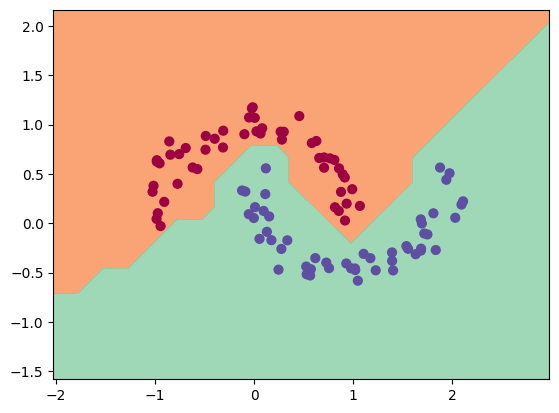

In [36]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

Finally, compare the solution to PyTorch. What's different? What's the same?

Play around with parameters and such.

MLP(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)
Epoch [1/100], Loss: 1.1531
Epoch [11/100], Loss: 0.7775
Epoch [21/100], Loss: 0.5357
Epoch [31/100], Loss: 0.4450
Epoch [41/100], Loss: 0.3996
Epoch [51/100], Loss: 0.3802
Epoch [61/100], Loss: 0.3700
Epoch [71/100], Loss: 0.3609
Epoch [81/100], Loss: 0.3507
Epoch [91/100], Loss: 0.3401
Epoch [101/100], Loss: 0.3294
Epoch [111/100], Loss: 0.3172
Epoch [121/100], Loss: 0.3031
Epoch [131/100], Loss: 0.2878
Epoch [141/100], Loss: 0.2725
Epoch [151/100], Loss: 0.2749
Epoch [161/100], Loss: 0.2565
Epoch [171/100], Loss: 0.2471
Epoch [181/100], Loss: 0.2208
Epoch [191/100], Loss: 0.2298
Epoch [201/100], Loss: 0.2124
Epoch [211/100], Loss: 0.1763
Epoch [221/100], Loss: 0.1658
Epoch [231/100], Loss: 0.1615
Epoch [241/100], Loss: 0.1271
Epoch [251/100],

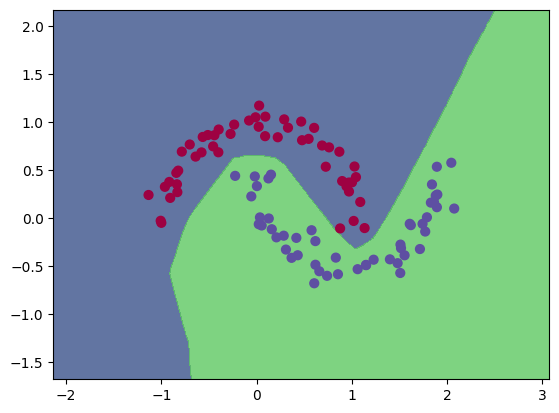

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, layer_sizes):
        super(MLP, self).__init__()
        layers = []
        for size in layer_sizes:
            layers.append(nn.Linear(input_size, size))
            layers.append(nn.ReLU())
            input_size = size
        # Remove the last ReLU for the output layer
        layers.pop()
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

# Initialize the model
input_size = 2
layer_sizes = [16, 16, 1]  # 2 hidden layers and 1 output layer
model = MLP(input_size, layer_sizes)
print(model)

# Prepare the data
X, y = make_moons(n_samples=100, noise=0.1)
y = y * 2 - 1  # make y be -1 or 1
y = y.reshape(-1, 1)  # reshape for PyTorch
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Training loop
for k in range(1000):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if k % 10 == 0:
        print(f'Epoch [{k+1}/100], Loss: {loss.item():.4f}')

# Plotting decision boundary
def plot_decision_boundary(model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
    Z = Z.detach().numpy()
    Z = (Z > 0).reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

# Visualize the decision boundary
plot_decision_boundary(model)
plt.show()


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, layer_sizes):
        super(MLP, self).__init__()
        layers = []
        for size in layer_sizes:
            layers.append(nn.Linear(input_size, size))
            layers.append(nn.Sigmoid())
            input_size = size
        # Remove the last ReLU for the output layer
        layers.pop()
        layers.append(nn.Softmax())
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

# Initialize the model
input_size = 2
layer_sizes = [3, 3, 1]  # 2 hidden layers and 1 output layer
model = MLP(input_size, layer_sizes)
print(model)

# Prepare the data
X, y = np.array([1, 0]), np.array([0, 1])
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # Mean Squared Error Loss
optimizer = optim.SGD(model.parameters(), lr=1)

# Training loop
for k in range(2):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if k % 10 == 0:
        print(f'Epoch [{k+1}/100], Loss: {loss.item():.4f}')


MLP(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=3, out_features=3, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=3, out_features=1, bias=True)
    (5): Softmax(dim=None)
  )
)


/home/tomf/.cache/pypoetry/virtualenvs/deep-learning-lecture-uWfDRtkd-py3.11/lib/python3.11/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


RuntimeError: size mismatch (got input: [1], target: [2])